## [Data Bootcamp Final Project](https://github.com/sc6354/data_bootcamp_final)
### Project Members: Susan Chen (sc6354), Brandon Eap (be678) , Chloe (Yue Chen, yc2938) 

In [1]:
#import packages
import pandas as pd 
import os 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
import matplotlib.collections as collections
%matplotlib inline
from IPython.display import display, Markdown
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import Layout, Box
pd.options.mode.chained_assignment = None
os.chdir("../data_bootcamp_final/data") 

## This notebook is divided into three sections: 
## 1. Analysis of Top App Categories
## 2. Comparison between Free and Paid
## 3. Topic Modeling of Negative Reviews

Our goal in section 1 is identify the most popular apps across all apps and across the different categories of app to identify which app categories is gaining traction. This can help app developers identify a category of app for which the market is not overly saturated. In section 2, we compare free and paid apps to gain a better understanding of how app pricing can impact ratings and other factors. Lastly, in section 3 we summarize negative reivews for a particular app with topic modeling. This can help app developers to quickly gauge the problems with the app.

In [2]:
# read in data
apps = pd.read_csv('googleplaystore.csv')
reviews = pd.read_csv('googleplaystore_user_reviews.csv')
#Brandon Directory
#apps = pd.read_csv('/Users/brandeap/Documents/GitHub/data_bootcamp_final/data/googleplaystore.csv')
#reviews = pd.read_csv('/Users/brandeap/Documents/GitHub/data_bootcamp_final/data/googleplaystore_user_reviews.csv')


## `Data Dictionary` 
This collection of datasets is available on [Kaggle.com](https://www.kaggle.com/lava18/google-play-store-apps). Since both datasets were compiled at the same by the same author, we did not think having two seperate csv files would be a issue. Additionally apps in the 'Reviews' dataset also appears in the 'Apps' dataset, thus excluding 'Reviews' would leave out important information about a particular app that is not contained in 'Apps'.

Apps: 
- App - Application Name 
- Category - Category the App belongs to 
- Rating - Overall user rating of the App
- Reviews - Number of user reviews for app 
- Size - Size of App 
- Installs - number of downloads 
- Type - Is the App paid or Free?
- Price - Price if not free 
- Content Rating - Age group the app is targeted at
- Genres - An app can belong to multiple genres (apart from its main category)

Reviews: 
- App - Name of App
- Translated_Review - user review
- Sentiment - Positive/Negative/Neutral 
- Sentiment_Polarity - Sentiment polarity score 
- Sentiment_Subjectivity - Sentiment subjectivity score 

## `Cleaning and Preprocessing`

In [3]:
print(apps.dtypes)

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


In [4]:
# this row appears to be problematic, the values are shifted one place up
apps.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                               19.0
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [5]:
apps.at[10472, ['Last Updated', 'Genres', 'Content Rating', 'Price', 'Type', 'Installs', 'Size', 'Reviews', 'Rating', 'Category']] = ['February 11, 2018', np.nan, 'Everyone', 0, 'Free', '1,000+', '3.0M', 19, 1.9, np.nan]
apps.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              NaN
Rating                                                1.9
Reviews                                                19
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                                NaN
Last Updated                            February 11, 2018
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [6]:
# Changing Data types
# change Rating, Reviews, Size, Installs, and Price to floats
apps['Rating'] = pd.to_numeric(apps['Rating'])
apps['Reviews'] = pd.to_numeric(apps["Reviews"])
# one megabyte is equal to 1000 kilobytes; convert kilobyte to megabyte by dividing by 1000 and remove the M
for i in range(len(apps)):
    if 'k' in apps.Size[i]:
        apps.Size[i] = pd.to_numeric(apps.Size[i][:-1])/1000
    elif 'M' in apps.Size[i]:
        apps.Size[i] = apps.Size[i][:-1]
    elif "Varies with device" in apps.Size[i]: 
        apps.Size[i] = np.nan
apps['Size'] = pd.to_numeric(apps['Size'])
apps['Installs'] = pd.to_numeric(apps['Installs'].str[:-1].str.replace(',', ''))
apps['Price'] = pd.to_numeric(apps['Price'].str.replace('$', ''))
apps['Last Updated'] = pd.to_datetime(apps['Last Updated'])

<ipython-input-6-ce94748e69d2>:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  apps['Price'] = pd.to_numeric(apps['Price'].str.replace('$', ''))


In [7]:
# create a year column based on last updated
apps['Last Updated']=pd.to_datetime(apps['Last Updated'])
Each_Year = apps['Last Updated'].dt.year
apps['Year']=Each_Year

In [8]:
# Removing duplicates
# the dataset was compiled by scaping the Google play store; as such duplicates can occur if an app listing was scaped twice or more
apps = apps.drop_duplicates(subset=['App'], keep="last")
apps

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Year
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000.0,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,2018
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,2018
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000.0,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,2018
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000.0,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,2018
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6,50000.0,Free,0.0,Everyone,Art & Design,2017-03-26,1.0,2.3 and up,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53.0,5000.0,Free,0.0,Everyone,Education,2017-07-25,1.48,4.1 and up,2017
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6,100.0,Free,0.0,Everyone,Education,2018-07-06,1.0,4.1 and up,2018
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5,1000.0,Free,0.0,Everyone,Medical,2017-01-20,1.0,2.2 and up,2017
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,NaN,1000.0,Free,0.0,Mature 17+,Books & Reference,2015-01-19,Varies with device,Varies with device,2015


In [9]:
for col in apps.columns[:-4]:
    print(col, ':', len(apps[col].unique()))

App : 9660
Category : 34
Rating : 40
Reviews : 5332
Size : 460
Installs : 21
Type : 3
Price : 93
Content Rating : 6
Genres : 119


There are 9660 apps in this dataset spanning 33 categories and 118 differnt genres. The number of categories is 33 because it is including NaN.

# `Section 1`

## 1.1 What are the top ten categories of apps by the amount of installs?

### One indicator for the success and popularity of an app is the amount of downloads/installs.

In [10]:
# rank categories by number of installs in each year
top_ten_cat = pd.DataFrame(apps.groupby(['Year', 'Category'])['Installs'].mean().sort_values(ascending=False))
top_ten_cat = top_ten_cat.reset_index()
cat_dfs = {year: top_ten_cat[top_ten_cat['Year'] == year] for year in top_ten_cat['Year'].unique()}

In [11]:
def plot_top(data_df, year, axes, metric):
    pd.set_option('display.float_format', str)
    data = data_df[year].head(10)
    plot = data.plot.barh(x = 'Category', y=metric ,color ='#ffb482', legend=False, ax = axes, fontsize=15)
    plot.axvline(data[metric].mean(), 0, 8, color='red')
    plot.set_title(str(year),fontsize= 15)
    plot.xaxis.grid(True)
    plot.yaxis.grid(False)
    return plot

<AxesSubplot:title={'center':'2018'}, ylabel='Category'>

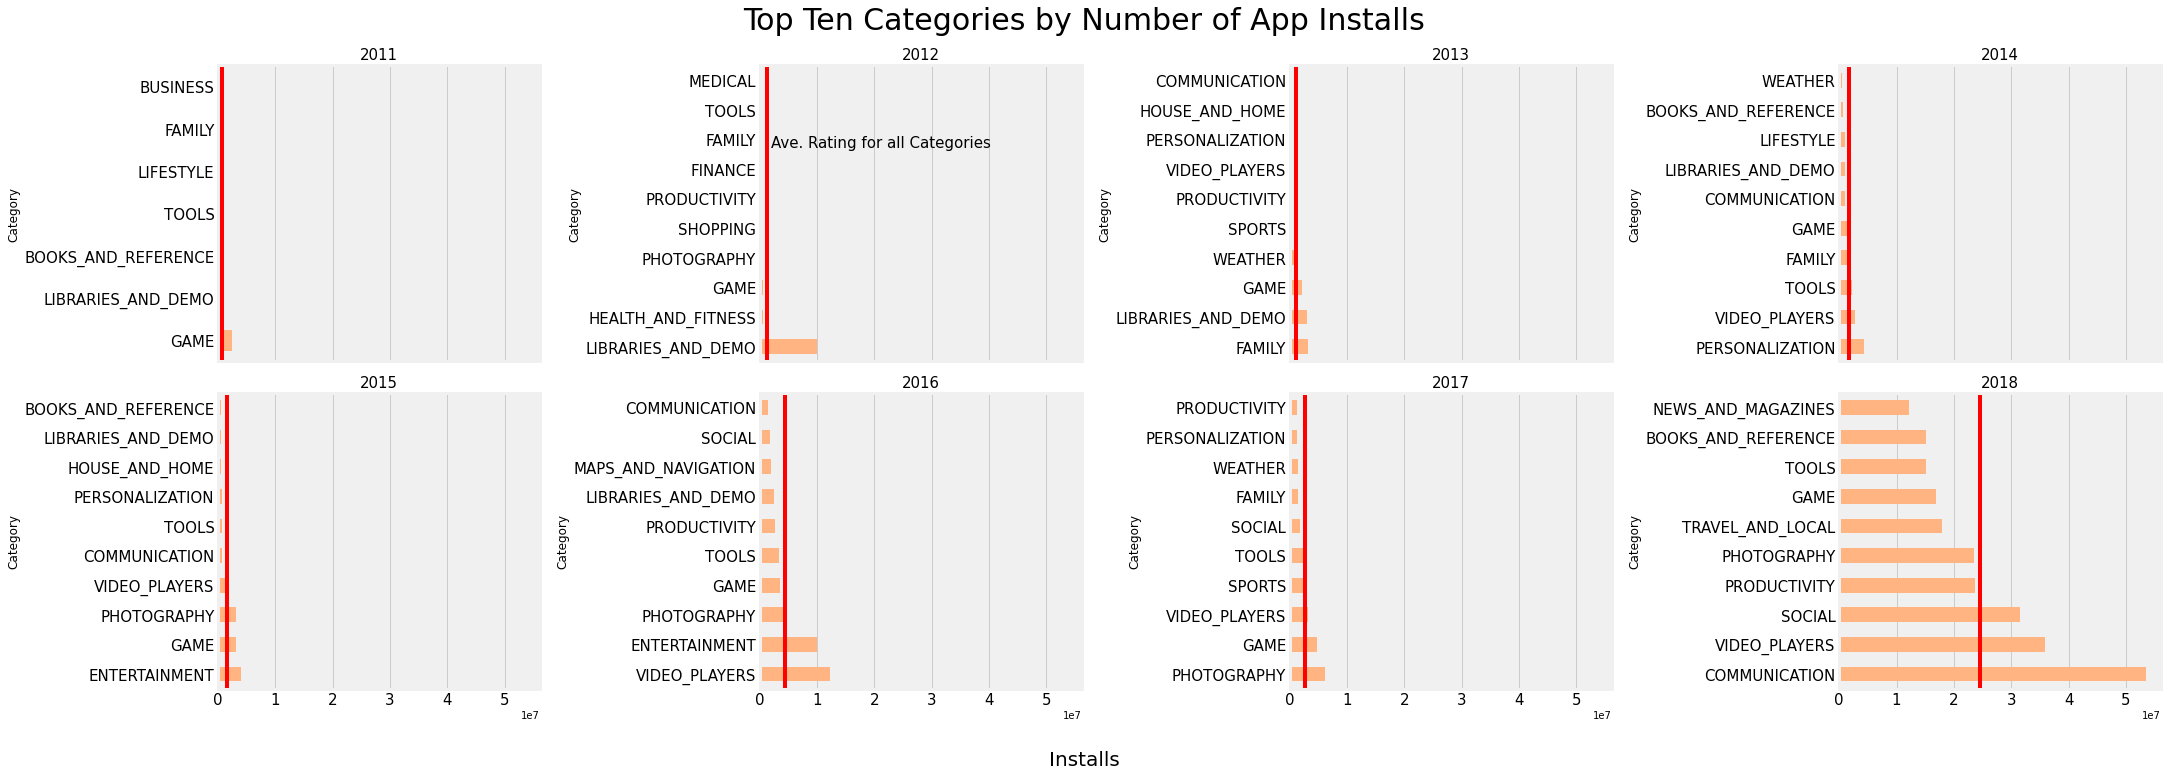

In [12]:
fig, axs = plt.subplots(figsize=(30,10), ncols= 4, nrows=2,sharex=True, constrained_layout=True)
fig.suptitle('Top Ten Categories by Number of App Installs', fontsize=30)
fig.text(0.5, -.05, 'Installs', ha='center', va='center', fontsize=20)
fig.text(0.355, .8, 'Ave. Rating for all Categories', fontsize=15)
plot_top(cat_dfs, 2011, axs[0,0], 'Installs')
plot_top(cat_dfs, 2012, axs[0,1], 'Installs')
plot_top(cat_dfs, 2013, axs[0,2], 'Installs')
plot_top(cat_dfs, 2014, axs[0,3], 'Installs')
plot_top(cat_dfs, 2015, axs[1,0], 'Installs')
plot_top(cat_dfs, 2016, axs[1,1], 'Installs')
plot_top(cat_dfs, 2017, axs[1,2], 'Installs')
plot_top(cat_dfs, 2018, axs[1,3], 'Installs')

Since 2011, the most popular category has changed and the number of downloads per category has also increased. This indicates that users are downloading more apps onto their phones and also downloading more apps that are in the same categories (i.e. a person can have many gaming apps on their phone). Another thing to note is that the GAME category has consistently remained within the top 5 apps by installs except in 2018. However, the amount of apps downloaded from the game category is still the highest in 2018, more than quadrupling its number of installs in 2017. To further compare against the other categories, the average amount of installs across all categories in 2018 is about 25 milllions installs, whereas the game category is almost 20 million installs. A similiar analysis can be done for other categories as well. 

In 2018, the top three most popular category of apps are COMMUNICATION, VIDEO_PLAYERS, and SOCIAL. COMMUNICATION did not make the top 10 categories in 2017, indicating user needs and wants has drastically changed within that time frame. Apps developers looking at this plot can easily inferred that users are not just looking for apps to entertain themselves, but also looking for apps that can keep them connected to their friends and family and for streaming and watching videos. Although our data ends at 2018, we believe this trend has probably accelerated throughout 2019 and 2020. 

## 1.2 What are the top ten categories of apps by the amount of ratings?

### Although looking at installs is a good way to gauge popularity, ratings is also a good way to see if users enjoy certain categories more than others.

In [13]:
# rank categories by rating in each year
top_ten_rating = pd.DataFrame(apps.groupby(['Year', 'Category'])['Rating'].mean().sort_values(ascending=False))
top_ten_rating = top_ten_rating.reset_index()
year_dfs = {year: top_ten_rating[top_ten_rating['Year'] == year] for year in top_ten_rating['Year'].unique()}

In [14]:
def plot_top_ratings(year, axes):
    data = year_dfs[year].head(10)
    barPlot = data.plot.barh(x = 'Category', y='Rating', color ='#a1c9f4', legend=False, ax = axes, fontsize=15)
    barPlot.axvline(data['Rating'].mean(), 0, 11, color='red')
    barPlot.set_xlim(3.5,4.8)
    barPlot.set_title(str(year),fontsize= 15)
    barPlot.xaxis.grid(True)
    barPlot.yaxis.grid(False)
    return barPlot


<AxesSubplot:title={'center':'2018'}, ylabel='Category'>

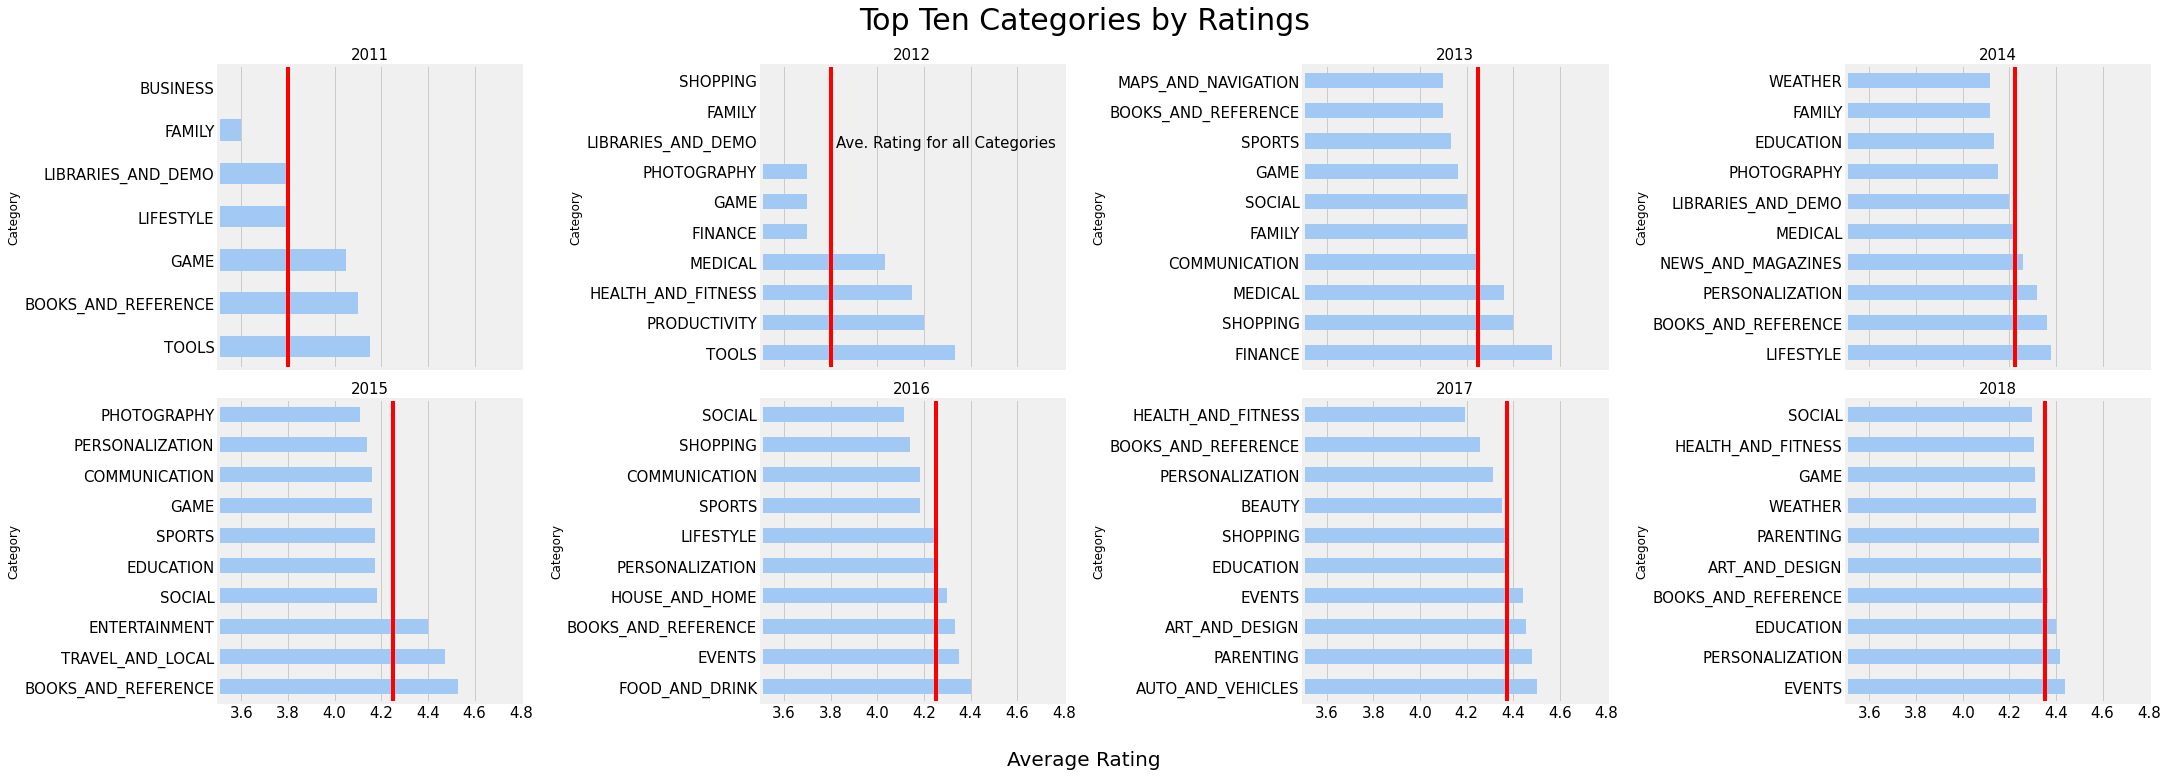

In [15]:
fig, axs = plt.subplots(figsize=(30,10), ncols= 4, nrows=2, sharex=True, constrained_layout=True)
fig.suptitle('Top Ten Categories by Ratings', fontsize=30)
fig.text(0.5, -.05, 'Average Rating', ha='center', va='center', fontsize=20)
fig.text(0.385, .8, 'Ave. Rating for all Categories', fontsize=15)
plot_top_ratings(2011, axs[0,0])
plot_top_ratings(2012, axs[0,1])
plot_top_ratings(2013, axs[0,2])
plot_top_ratings(2014, axs[0,3])
plot_top_ratings(2015, axs[1,0])
plot_top_ratings(2016, axs[1,1])
plot_top_ratings(2017, axs[1,2])
plot_top_ratings(2018, axs[1,3])


The results of ranking apps by ratings is drastically different than ranking apps by number of install. In every year, the top app category by installs is not one of the top ten most downloaded app categories for that year. This means that the least popular apps have ratings that are skewed to the left since less user use the app and of those who do, they leave more postive reviews than negative reviews. The game category is one of the top ten most downloaded categories every year and yet it is not consistently one of the top ten highest rated categories.  In fact, the GAME category did not make it into the top 10 categories by rating in the years 2014, 2016, and 2017. In 2018, the events category had highest average rating and only the top three categories had average ratings above the average rating of all categories. However, if a category has low users and high ratings, then the ratings are not good indicators of popularity and success.

## 1.3 What are the top ten categories of apps by the amount of installs and ratings?

In [16]:
# calculate score
apps['Score'] = (apps['Reviews']/apps['Installs'])*apps['Rating']
# rank categories by score in each year
top_ten= pd.DataFrame(apps.groupby(['Year', 'Category'])['Score'].mean().sort_values(ascending=False))
top_ten= top_ten.reset_index()
top_dfs = {year: top_ten[top_ten['Year'] == year] for year in top_ten['Year'].unique()}



<AxesSubplot:title={'center':'2018'}, ylabel='Category'>

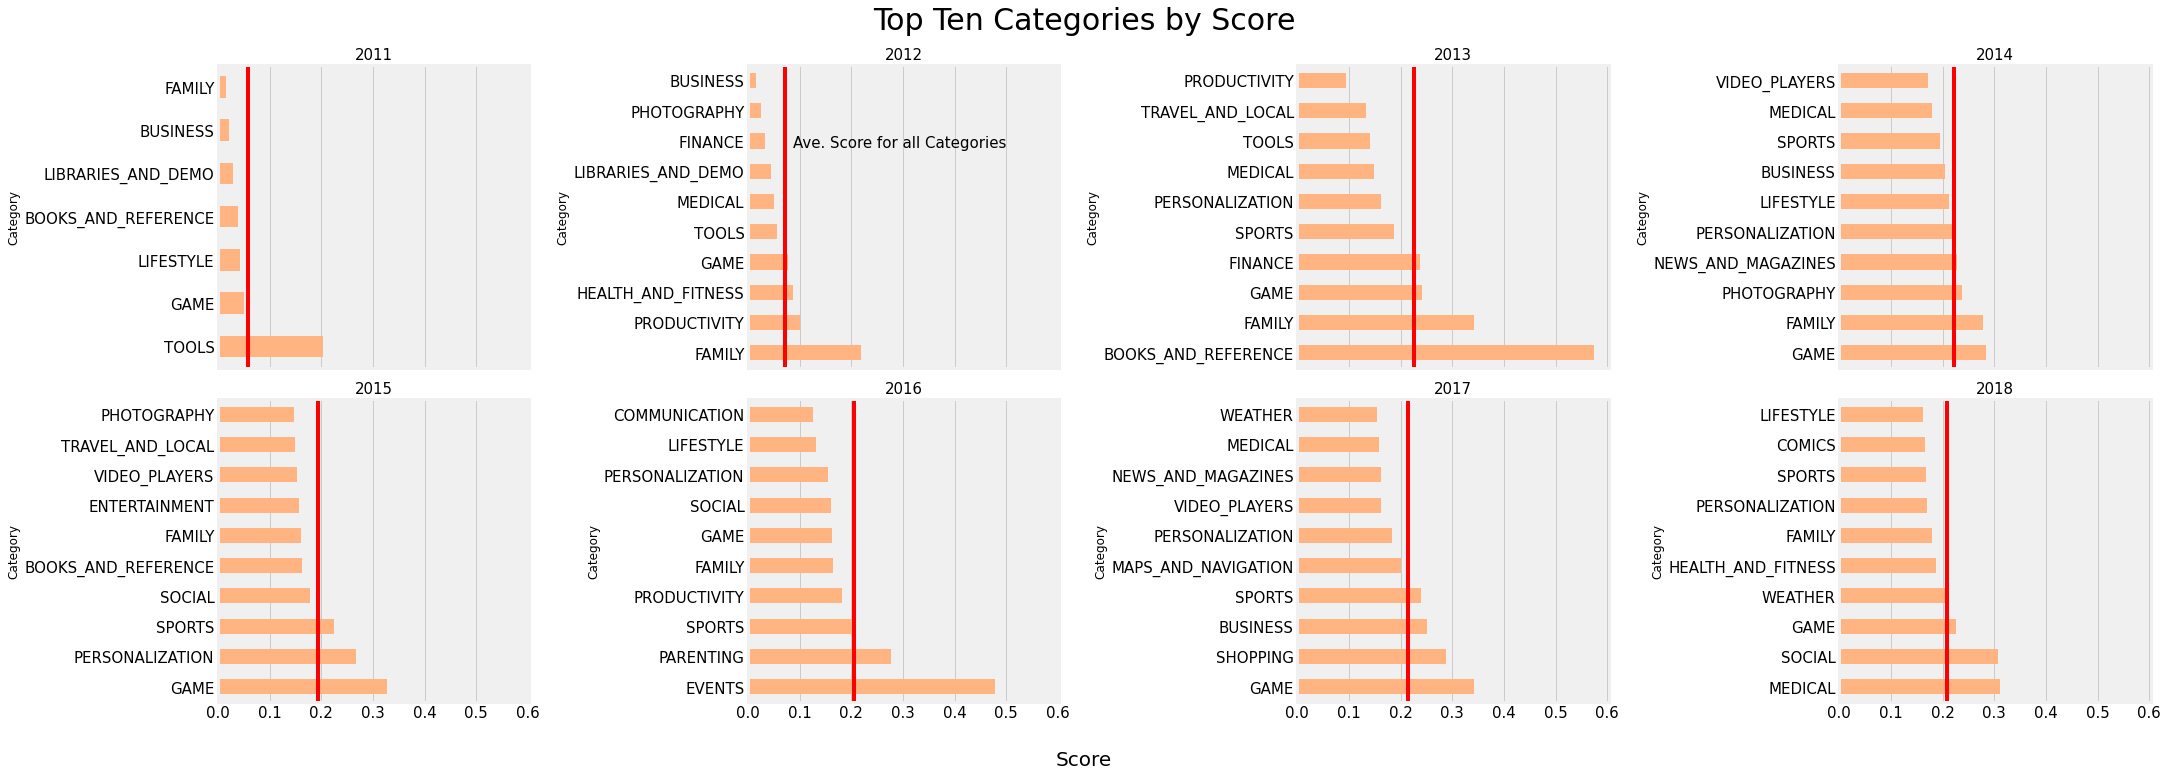

In [17]:
fig, axs = plt.subplots(figsize=(30,10), ncols= 4, nrows=2, sharex=True, constrained_layout=True)
fig.suptitle('Top Ten Categories by Score', fontsize=30)
fig.text(0.5, -.05, 'Score', ha='center', va='center', fontsize=20)
fig.text(0.365, .8, 'Ave. Score for all Categories ', fontsize=15)
plot_top(top_dfs, 2011, axs[0,0], 'Score')
plot_top(top_dfs, 2012, axs[0,1], 'Score')
plot_top(top_dfs, 2013, axs[0,2], 'Score')
plot_top(top_dfs, 2014, axs[0,3], 'Score')
plot_top(top_dfs, 2015, axs[1,0], 'Score')
plot_top(top_dfs, 2016, axs[1,1], 'Score')
plot_top(top_dfs, 2017, axs[1,2], 'Score')
plot_top(top_dfs, 2018, axs[1,3], 'Score')


To consider both installs and ratings, we divided each app's total number of reviews by it total number of installs. The resulting number is multiplied by the app's rating and the overall score is averaged across the different categories. A high score means that most users who download an app in a specific category also make a review on the app. If more users review an app, then the app's rating is more representative of people who actually use the app. This can be a better measure of satisfaction that simply comparing the rating. Likewise, a low score means that most users who download an app do not review the app. 

This plot contains two important observations. The first is that no category has a score higher than .5 with the exception of BOOKS_AND_REFERENCES in 2013. This means that less that half of all users who download an app actually review it. The other point is that the average score has not change significantly since 2011, indicating that most users do not leave a review and this reviewing preference is likely to persist. From 2015 to 2018, the top categories are GAME, EVENTS, GAME, and MEDICAL, all of which are categories that can be considered as forms of entertainment except MEDICAL. Because these categories are the most reviewed, it demonstrates that users care on average more when their gaming app fails or when their social media apps are not working. The GAME category is one of the most popular categories, but its average rating in recent years was less than the average rating for all categories in the same year. The graph adds the story by indicating that although the GAME category is one of the most popular category, it also has apps that are reviewed no more and no less than apps in other categories. Thus the comparison by rating is not as deceptive as we initially thought it to be.

## 1.4 What are the top ten categories of apps by the amount of installs and ratings?

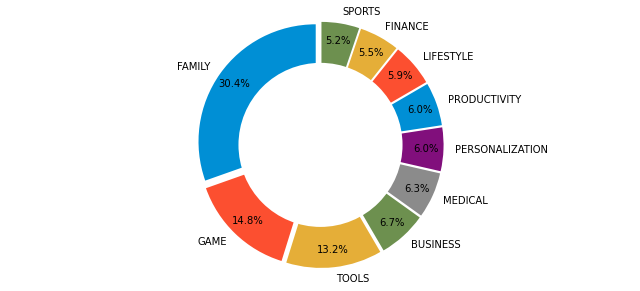

In [18]:
top_number_apps = apps.groupby('Category')['App'].count().sort_values(ascending=False).head(10)
top_number_apps.sort_values(ascending=True)
fig,ax = plt.subplots()
top_number_apps.plot.pie(ax=ax, figsize=(10,5), textprops={'fontsize': 10}, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05))
ax.set_ylabel('')
ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

Although the game category has the most average installs and ratings, the family category has the most amount of apps in the Google Play Store. However, the family category includes casual games like board games, puzzles, and kids games, which indicates that games are still the most popular category.

# `Section 2: Comparing Free and Paid Apps`

## 2.1 What is the breakdown of App types (free or paid)?

Text(0, 0.5, 'Total Number')

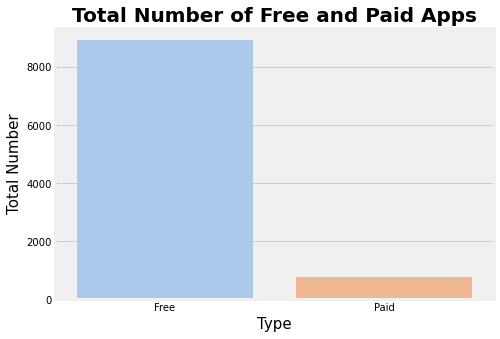

In [19]:
fig,ax = plt.subplots(figsize=(7,5))
sns.countplot(x='Type',data=apps, palette=('#a1c9f4', '#ffb482'))
ax.set_title('Total Number of Free and Paid Apps', loc='center', fontsize=20, fontweight='bold')
ax.set_xlabel('Type',fontsize=15)
ax.set_ylabel('Total Number',fontsize=15)

As expected, there are more free apps than paid apps. Most apps in the Google Play store and iTunes follow a "freemium" model, in which it is free to download the app, but the app can have microtransactions (i.e. most gaming apps) or fees after trial. Thus, we cannot say that free apps are entirely free since some may charge a one-time fee for extra features or a monthly/yearly subscription fee for use after the trial period even if it is free to download. This is also consistent with our belief because most users prefer free apps or apps with some ads, leading app developers and  businesses (i.e. apps for ecommmerce) to price their apps at $0 to encourage usage by users.

## 2.2 Growth of Free and Paid Apps

In [20]:
time_d=pd.DataFrame()
for i in range(2012,2019,1):
    td = apps.loc[apps['Year'] == i,:]
    for m in td['Type'].unique():
        time_d.loc[i,m]= td.loc[td['Type']==m,'Type'].count()
time_d

,Free,Paid,NaN
2012,21.0,5.0,NaN
2013,80.0,28.0,NaN
2014,149.0,54.0,NaN
2015,368.0,80.0,NaN
2016,689.0,90.0,NaN
2017,1624.0,170.0,NaN
2018,5961.0,324.0,0.0


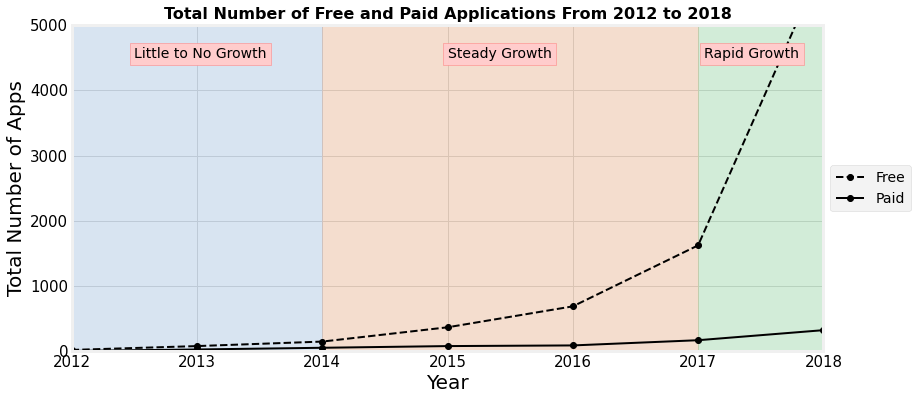

In [21]:
fig,ax= plt.subplots(1,1,figsize=(12,6))
plt.grid(True)
plt.style.use('fivethirtyeight')
patches = []
rect1 = plt.Rectangle((2012.0, 0.0), 2.0, 5000)
rect2 = plt.Rectangle((2014.0, 0.0), 3.0, 5000)
rect3 = plt.Rectangle((2017.0, 0.0), 2.0, 5000)
patches.append(rect1)
patches.append(rect2)
patches.append(rect3)
p = collections.PatchCollection(patches, color =('#a1c9f4', '#ffb482', '#8de5a1'), alpha=.3) 
ax.add_collection(p)
# plot lines
time_d['Free'].plot(ax=ax,marker='o', ls= '--',lw = 2,color='black')
time_d['Paid'].plot(ax=ax,marker='o',lw = 2,color='black')
ax.set_title('Total Number of Free and Paid Applications From 2012 to 2018',size = 16,fontweight='bold')
ax.set_ylim(0,5000)
ax.set_xlim(2012,2018)
ax.set_ylabel('Total Number of Apps',size=20)
ax.set_xlabel('Year',size=20)
plt.text(2012.5, 4500, 'Little to No Growth', bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
plt.text(2015, 4500, 'Steady Growth', bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
plt.text(2017.05, 4500, 'Rapid Growth', bbox=dict(boxstyle="square",ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))                 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

This time series lines up with changes to the Play Store also exactly as when those changes were put into place. Our goal with this plot and the following plot is to help explain and visualize the rise of free apps after 2017. Google's Play Store and Apple's App Store first launched in 2008. Since our dataset only contains information about Google Play Store apps since 2012, we refrain from applying our analysis to earlier years and Apple apps (althought a similiar case can be made too). This graph can be generally divided into three phases: pratically no growth (2012-2014); steadily growth (2014-2017); and rapid growth (2017-present). Uncoincidentally, Google implemented drastic changes at the start of each of those phases. Prior to 2014, Google did not make huge improvements to its app stores besides increasing the app size from 2GB to 4GB and adding in-app billing. 

In 2015, Google introduced tools that make it eaiser for app developers to create apps such as A/B test experiments. This changes was further complemented by a series of changes in 2016 that included labeling apps with ads, introducing more pre-launch tools for developers, introducing new app categories, and most importantly changing the revenue model for developers. Instead of earning 70% of revenue from app subscritions, developers can now earned 85% of revenue. This change was perhaps the most significant since developers can effectively make more revenue per app. Post 2017 Play Store is essentially the storefront that users are accustomed to seeing. Google introduced the Play Store to all Chromebooks in 2017. This single change is very likely to have resulted in the rapid uptick of downloads of free apps because previously, user could only download apps on an Andriod phone. By allowing user to also have access to their apps on their Chromebooks, Google has widen the market for play store apps and eroded the line between computer applications and mobile applications. 

## 2.3 Distribution of Free and Paid App Ratings by Year

In [22]:
# average ratings by app price
type_agg=apps.groupby('Type').mean()
type_agg['Count']=apps.groupby('Type')['App'].count()
type_agg

,Rating,Reviews,Size,Installs,Price,Year,Score,Count
Type,,,,,,,,
Free,4.165872284397634,234254.8417742841,20.514552193548376,8447756.726108927,0.0,2017.4025828186411,0.13931457023930177,8905
Paid,4.262126245847174,8746.37400530504,19.049633967789156,76079.2851458886,14.055901856763773,2016.6777188328913,0.49807092727574725,754


In [23]:
@interact
def hist(Year = widgets.IntRangeSlider(description='Year(s):',min=2012, max=2018, step =1,value= [2012,2012],)):
    fig,ax = plt.subplots(figsize=(15,8))
    #if Year == 'All years':
     #   sns.histplot(data=apps,x='Rating', color='#a1c9f4', stat='count', bins=10, kde=True)
    #else: 
    # filter data by the year range
    data = apps[(apps['Year']>=Year[0]) & (apps['Year']<=Year[1])]
    sns.histplot(data=data,x='Rating', color='#a1c9f4', stat='count', bins=10, kde=True)
    range= ""
    if Year[0]== Year[1]:
        range = str(Year[0])
    else:
        range = str(Year[0]) + ' to ' + str(Year[1])

    free_avg = data[data['Type']== 'Free']['Rating'].mean()
    paid_avg = data[data['Type']== 'Paid']['Rating'].mean()
    avg = data['Rating'].mean()
    plt.axvline(free_avg, 0, 11, color='red')
    plt.axvline(paid_avg, 0, 11, color='green')
    plt.axvline(avg, 0, linewidth='5', linestyle=':',color='black' )
    ax.set_title('Distributions of All App Rating for ' + range, loc='center', fontsize=20,fontweight='bold')
    ax.set_xlabel('Ratings',fontsize=20)
    ax.set_ylabel('Total Number of Apps',fontsize=20)
    plt.legend(['Distribution Line','Average Rating of Free Apps', 'Average Rating of Paid Apps', 'Average of all Apps'],fontsize = 20, loc='best')
    plt.tick_params(labelsize=20)


interactive(children=(IntRangeSlider(value=(2012, 2012), description='Year(s):', max=2018, min=2012), Output()…

This is an interactive plot. Since sumbitting a pdf file would remove the plot, we have attached an image of one of the visualization views for the years 2012 to 2018.

![title](plots/ratingsByAppType.png)

As shown in the graph, the paid apps have better average rating than the free apps from 2012 to 2018. High average rating of paid apps can be attributed to smaller customer base, leading to fewer reviews. Based on this dataset, the total number of paid apps' reviews was 45 times fewer than that of free apps. In comparison to free apps, there were also 12 times fewer paid apps in the market. This also led to a better rating of paid apps.
The average rating of paid and that of free apps have also changed respectively. The average rating of free apps for 2012 to 2013 was about 4.0, and it increased to about 4.2 for 2017 to 2018. The average rating of paid apps has also shown an increasing trend. At the same time, the gap between paid apps and free apps were also narrowing. This means that the both paid apps and free apps have receive better reviews in 2018 compared to 2012.


# `Section 3: Topic Modeling of Reviews `

In this section, we analyze app reviews. Apps can acquire a plethora of reviews and it is often impractical for a business or developer to read them all. A quicker and less costly option to summarize reviews and extract the key points. This is our goal for this section. We focus our model on negative reviews because it more advantageous for a developer to look into negative reviews than it is to look into positive reviews when attempting to figure out what features of their app to improve and debug.

In [24]:
reviews

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.0,0.5333333333333333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.2884615384615384
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.4,0.875
4,10 Best Foods for You,Best idea us,Positive,1.0,0.3
...,...,...,...,...,...
64290,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64291,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64292,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN
64293,Houzz Interior Design Ideas,NaN,NaN,NaN,NaN


In [25]:
# remove rows with NaN
reviews = reviews.dropna()
# check how many apps are in the reviews dataset and subset the one with the most reviews to model
reviews.App.value_counts()

Bowmasters                                            312
Angry Birds Classic                                   273
Helix Jump                                            273
Calorie Counter - MyFitnessPal                        254
Candy Crush Saga                                      240
                                                     ... 
Free Live Talk-Video Call                               1
Drawing for Kids Learning Games for Toddlers age 3      1
Caf - Mon Compte                                        1
Draw A Stickman                                         1
Draw In                                                 1
Name: App, Length: 865, dtype: int64

In [26]:
apps[apps["App"]=='Bowmasters']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Year,Score
6077,Bowmasters,GAME,4.7,1535581,NaN,50000000.0,Free,0.0,Teen,Action,2018-07-23,2.12.5,4.1 and up,2018,0.144344614


In [27]:
# create a dataframe of the App with the most reviews
bm_df = reviews[reviews['App']=="Bowmasters"]
bm_df

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
16887,Bowmasters,Really like game far. Great gameplay lots fun....,Positive,0.1166666666666666,0.5425925925925927
16888,Bowmasters,Easy play round two minutes. Characters hilari...,Positive,0.1651515151515151,0.5606060606060607
16889,Bowmasters,I would give game stars many problems. Lag eve...,Negative,-0.3571428571428571,0.5714285714285714
16890,Bowmasters,"It's ok, making us pay per week ads absurd edi...",Positive,0.0166666666666666,0.4416666666666666
16891,Bowmasters,"Should vary videos required watch, least give ...",Positive,0.0428571428571428,0.3942857142857143
...,...,...,...,...,...
17202,Bowmasters,It really good lots fun addictive I would say ...,Positive,0.0714285714285714,0.5142857142857143
17203,Bowmasters,Its pretty addicting please fix guy CD broken....,Positive,0.0166666666666666,0.5333333333333333
17204,Bowmasters,This magical game children play. If like wonde...,Positive,0.175,0.7
17205,Bowmasters,Little reason keep playing. Only way earn coin...,Positive,0.0224999999999999,0.52


## 3.1 Starting off easy: How many negative reviews do Bowmasters have?

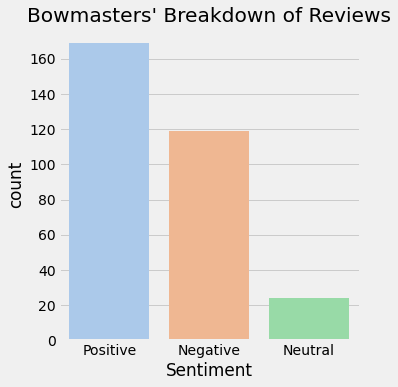

In [28]:
display(Markdown('## 3.1 Starting off easy: How many negative reviews do Bowmasters have?'))
sns.catplot(x="Sentiment", kind="count", data=bm_df, palette="pastel").set(title="Bowmasters' Breakdown of Reviews")


The barplot clearly illustrates that approximately half of Bowmaster's reviews are either negative or neutral. Although Bowmasters has a high rating of 4.7, the plot illustrates that not all users are satified with the app. This not a good situation to be in as the app clearly has room to improve. 

## 3.2 We know that Bowmasters has many negative reviews but what are users complaining about?'

In [29]:
neg_reviews = bm_df[bm_df["Sentiment"]=="Negative"]
neg_reviews

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
16889,Bowmasters,I would give game stars many problems. Lag eve...,Negative,-0.3571428571428571,0.5714285714285714
16895,Bowmasters,The game entertaining game randomly send ad pa...,Negative,-0.26,0.5
16900,Bowmasters,This game great even 5 year old brother plays ...,Negative,-0.0365327380952381,0.4559523809523809
16901,Bowmasters,I rate 4 stars ads chests really annoying I'm ...,Negative,-0.1827272727272727,0.5709090909090909
16905,Bowmasters,I got I really like it! Too much blood too! An...,Negative,-0.0208333333333333,0.4666666666666666
...,...,...,...,...,...
17196,Bowmasters,Loved game. Hated would freeze everytime I ref...,Negative,-0.1083333333333333,0.5750000000000001
17198,Bowmasters,Ad based chest drops horrendous game whole mem...,Negative,-0.1,0.4
17199,Bowmasters,I really like game fun play crashes often. Als...,Negative,-0.0133333333333333,0.2466666666666666
17201,Bowmasters,Great game pass time with. Almost reminds angr...,Negative,-0.0333333333333333,0.7166666666666667


In [30]:
import re
import nltk
from pprint import pprint 
from nltk.corpus import stopwords
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [31]:
# NLTK stop words
stop_words = stopwords.words('english')
neg = neg_reviews['Translated_Review'].values.tolist()

In [32]:
print(neg[10:15])
# the reviews look pretty cleans, so we can move straight into tokenizaiton 

['Loved game. Hated would freeze everytime I refused targeted ads. Disappointed. Was really enjoying much', "Ad based chest drops horrendous game whole member ship scheme y'all adopted pitiful happened buying 2 bucks", "I really like game fun play crashes often. Also I get passed second opponent tournament mode screen goes black I can't continue.", 'Great game pass time with. Almost reminds angry birds', 'Its fun short round pvp ridiculously gruesome kill scenes done cartoon fashion. Nothing negative say; I look forward unlocking characters.']


In [33]:
# function tokenize words 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

review_words = list(sent_to_words(neg))
print(review_words[:1])

[['would', 'give', 'game', 'stars', 'many', 'problems', 'lag', 'everywhere', 'game', 'ads', 'make', 'worse', 'mind', 'watching', 'game', 'awful', 'it', 'makes', 'gameplay', 'unplayable', 'unenjoyable', 'please', 'fix', 'problems']]


In [34]:
# these are functions for removing stopwords, creating bigrams and trigrams, performing lemmatization 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

bigram = gensim.models.Phrases(review_words , min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[review_words ], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [35]:
# Remove Stop Words
rev_words_nostops = remove_stopwords(review_words)
# Form Bigrams
rev_words_bigrams = make_bigrams(rev_words_nostops)
# Initialize spacy 'en' model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Perform lemmatization keeping only noun, adj, vb, adv
rev_lemmatized = lemmatization(rev_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print the first review to view results
print(rev_lemmatized[:1])

[['give', 'game', 'star', 'many', 'problem', 'lag', 'everywhere', 'game', 'ad', 'make', 'bad', 'mind', 'watch', 'game', 'awful', 'make', 'gameplay', 'unplayable', 'unenjoyable', 'fix', 'problem']]


In [36]:
# create corpus 
words = corpora.Dictionary(rev_lemmatized)
# create term document frequency 
corpus = [words.doc2bow(rev) for rev in rev_lemmatized]
print(corpus[:1])
words[0]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1)]]


'ad'

In [37]:
# build the LDA topic model assuming that the number of topics is 10
topics = gensim.models.ldamodel.LdaModel(corpus = corpus,id2word= words,num_topics=10,random_state=100,
                                         update_every=1,chunksize=30,alpha='auto',per_word_topics=True)

In [38]:
# View topics
pprint(topics.print_topics())
doc_lda = topics[corpus]

[(0,
  '0.083*"game" + 0.039*"chest" + 0.036*"reward" + 0.032*"player" + '
  '0.029*"great" + 0.026*"pass" + 0.026*"buy" + 0.026*"member" + 0.026*"ship" '
  '+ 0.026*"time"'),
 (1,
  '0.126*"game" + 0.052*"fun" + 0.050*"ad" + 0.033*"match" + 0.029*"good" + '
  '0.025*"minute" + 0.024*"weapon" + 0.023*"bloody" + 0.022*"pop" + '
  '0.020*"think"'),
 (2,
  '0.070*"happen" + 0.069*"ad" + 0.068*"watch" + 0.067*"online" + '
  '0.064*"never" + 0.064*"still" + 0.052*"hit" + 0.049*"time" + 0.042*"win" + '
  '0.033*"die"'),
 (3,
  '0.123*"game" + 0.064*"make" + 0.040*"problem" + 0.039*"horrible" + '
  '0.037*"many" + 0.035*"video" + 0.033*"give" + 0.032*"suck" + 0.029*"people" '
  '+ 0.027*"bad"'),
 (4,
  '0.068*"get" + 0.053*"second" + 0.044*"game" + 0.037*"screen" + '
  '0.036*"tournament" + 0.035*"also" + 0.033*"crash" + 0.032*"chance" + '
  '0.031*"degree" + 0.030*"fun"'),
 (5,
  '0.043*"ad" + 0.042*"always" + 0.037*"pvp" + 0.037*"character" + '
  '0.035*"chest" + 0.028*"second" + 0.028*"rea

### Topic 0 is represented as 0.083*"game" + 0.039*"chest" + 0.036*"reward" + 0.032*"player" + 0.029*"great" + 0.026*"pass" + 0.026*"buy" + 0.026*"member" + 0.026*"ship" '+ 0.026*"time". This means that the top 10 terms that contribute to Topic are 'game', 'chest', 'reward', and so on. The probability or weight of 'game' on Topic 0 is .083. The greater the weight, the more important that term is to the topic.

In [39]:
# Evaluating the model with perplexity and coherence scores
print('\nPerplexity: ', topics.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=topics, texts=rev_lemmatized, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.874260210677197

Coherence Score:  0.5788043767975338


### Perplexity is how well the model fits the data and lower the value, better the fit. However, the statistic alone is meaningless, since we do not have anything to compare it to. 

In [40]:
# Run topic modeling with different nums of topics, and compute perplexity and coherence for each model 
def compute_scores(dictionary, corpus, texts, limit, start=2):
    perplexity_scores = []
    coherence_scores =[]
    models=[]
    for num_topics in range(start, limit):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word= words, num_topics=num_topics, random_state=100, update_every=1,
                                                chunksize=30, alpha='auto')
        models.append(model)
        perplexity = model.log_perplexity(corpus)
        perplexity_scores.append(perplexity)
        coherenceModel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherenceModel.get_coherence())
    return models, perplexity_scores, coherence_scores

In [41]:
model_list, perplexity_scores, coherence_scores = compute_scores(dictionary=words, corpus=corpus, texts = rev_lemmatized, start=2, limit = 25)

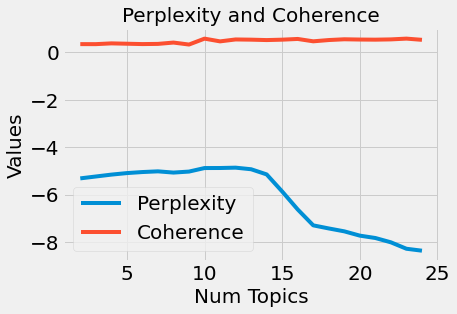

In [42]:
# plot modeling results 
limit=25
start=2
x = range(start, limit)
plt.plot(x, perplexity_scores)
plt.plot(x, coherence_scores)
plt.figsize =(5,7)
plt.title("Perplexity and Coherence", fontsize = 20)
plt.xlabel("Num Topics", fontsize = 20)
plt.ylabel("Values", fontsize = 20)
plt.legend(['Perplexity', 'Coherence'],fontsize = 20, loc='best')
plt.tick_params(labelsize=20)
plt.show()

The coherence score does not increase as the number of topics increase. Up to 15, the perplexity score does not decrease as the number of topics increase. This indicates that the ideal number of topics is likely to between 2 and 10. We avoid selecting any number over 10, since the model could overfit the data and create topics that have too much overlap. 

In [43]:
# Select the k = 5 as the optimal model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.069*"game" + 0.037*"player" + 0.033*"reward" + 0.028*"include" + '
  '0.026*"great" + 0.023*"buy" + 0.023*"server" + 0.023*"member" + '
  '0.023*"ship" + 0.023*"play"'),
 (1,
  '0.087*"game" + 0.058*"ad" + 0.033*"use" + 0.030*"get" + 0.028*"stop" + '
  '0.027*"much" + 0.026*"virus" + 0.026*"randomly" + 0.025*"also" + '
  '0.025*"match"'),
 (2,
  '0.042*"ad" + 0.040*"online" + 0.033*"watch" + 0.032*"happen" + '
  '0.030*"still" + 0.030*"never" + 0.028*"pvp" + 0.026*"game" + 0.024*"hit" + '
  '0.022*"time"'),
 (3,
  '0.114*"game" + 0.045*"make" + 0.029*"well" + 0.020*"problem" + 0.019*"lag" '
  '+ 0.018*"time" + 0.018*"horrible" + 0.018*"bad" + 0.018*"many" + '
  '0.016*"mode"'),
 (4,
  '0.088*"game" + 0.050*"fun" + 0.027*"second" + 0.026*"get" + 0.024*"play" + '
  '0.021*"screen" + 0.019*"suck" + 0.019*"degree" + 0.018*"tournament" + '
  '0.018*"pass"'),
 (5,
  '0.052*"game" + 0.041*"chest" + 0.037*"character" + 0.037*"always" + '
  '0.036*"get" + 0.031*"ad" + 0.027*"coin" + 0

In [44]:
# visualize the optimal model, namely the top 10 terms in each topic
def plot_topics (topic_num, axs):
    topic_dict = {}
    for i in range(len(optimal_model.show_topic(topic_num))):
        topic_dict[optimal_model.show_topic(topic_num)[i][0]] = optimal_model.show_topic(topic_num)[i][1]

    topic_terms = list(topic_dict.keys())
    beta = [float(topic_dict[k]) for k in topic_terms]
    plot = sns.barplot(x=beta, y = topic_terms, color = 'blue', ax = axs)
    plot.set_title("Topic " + str(topic_num +1), fontsize=25)
    plot.tick_params(labelsize=20)
    return plot

<AxesSubplot:title={'center':'Topic 5'}>

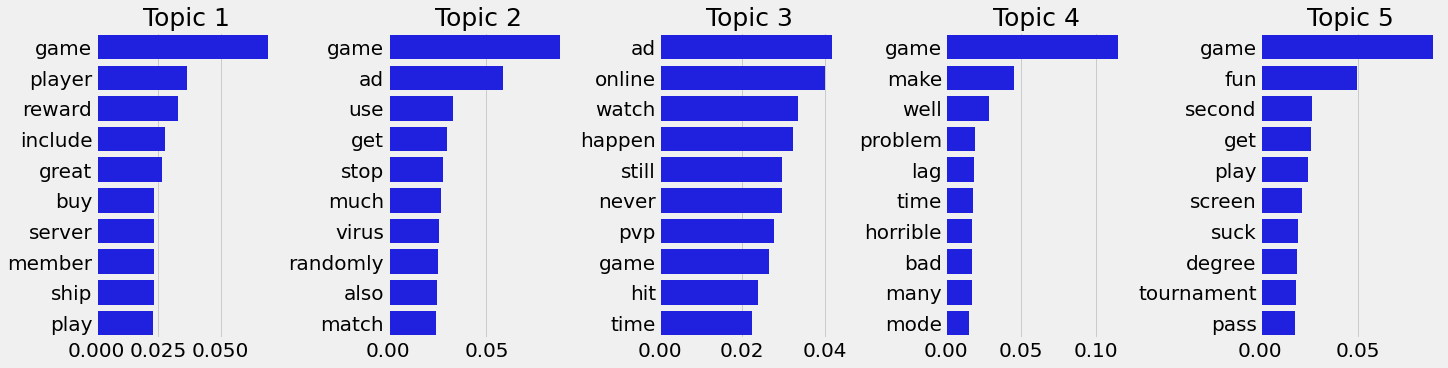

In [45]:
plt.rcParams["figure.figsize"] = (20,5)
fig, axs = plt.subplots(ncols= 5, constrained_layout=True)
plot_topics(0, axs[0])
plot_topics(1, axs[1])
plot_topics(2, axs[2])
plot_topics(3, axs[3])
plot_topics(4, axs[4])

Judging from these topics, if we did not know that Bowmasters is a gaming application, the topics make it very obvious that it is. Its seems like Bowmasters' most prevalent problems are perhaps too many microtransactions in the game, too many ads, a persistent and horrible lag, and screen freezes or blackouts. Since topics 2 and 3 both contain 'ad', it might be in Bowmasters' interest to resolve this issue first. A similiar analysis can be conduct for Bowmasters' positive review to gauge areas of their App that they are excelling in.